In [ ]:
!pip install seaborn

In [ ]:
import argparse
import os
import numpy as np
from typing import List, Tuple, Dict, Any
from pathlib import Path
import logging
import pandas as pd
from sklearn.base import BaseEstimator
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import string
import re
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from transformers import AutoTokenizer, AutoModel
from gensim.models import FastText, Word2Vec
import numpy as np
import logging
import time
from typing import List, Tuple, Dict, Any
import matplotlib.pyplot as plt
import seaborn as sns
import time
import torch

In [ ]:
def initialize_bert():
    """Initialize BERT model and tokenizer"""
    tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
    model = AutoModel.from_pretrained('bert-base-uncased')
    return tokenizer, model


def get_bert_embeddings(texts: List[str], embedding_size: int = 100) -> np.ndarray:
    """
    Generate BERT embeddings for texts using GPU if available
    Args:
        texts: list of texts to embed
        embedding_size: not used for BERT but kept for consistent interface
    Returns:
        numpy array of embeddings
    """
    tokenizer, model = initialize_bert()

    # Check GPU availability
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    logger.info(f"Using device: {device}")

    try:
        # Move model to GPU if available
        model = model.to(device)
        embeddings = []

        # Process in batches
        batch_size = 128
        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i:i + batch_size]

            # Tokenize and prepare input
            encoded = tokenizer(
                batch_texts,
                padding=True,
                truncation=True,
                max_length=512,
                return_tensors='pt'
            )

            # Move input tensors to GPU if available
            encoded = {k: v.to(device) for k, v in encoded.items()}

            # Generate embeddings
            with torch.no_grad():
                outputs = model(**encoded)
                # Move to CPU and convert to numpy
                batch_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
                embeddings.append(batch_embeddings)

            # Log progress for long sequences
            if (i + batch_size) % (batch_size * 10) == 0:
                logger.info(f"Processed {i + batch_size} texts out of {len(texts)}")

        # Stack all embeddings
        return np.vstack(embeddings)

    except RuntimeError as e:
        if "out of memory" in str(e):
            logger.error("GPU out of memory. Trying with smaller batch size...")
            # Clear GPU memory
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
            # Recursively try with smaller batch size
            return get_bert_embeddings_with_batch_size(texts, batch_size // 2, tokenizer, model, device)
        else:
            raise e
    except Exception as e:
        logger.error(f"Error during embedding generation: {str(e)}")
        raise


def get_bert_embeddings_with_batch_size(
        texts: List[str],
        batch_size: int,
        tokenizer,
        model,
        device
) -> np.ndarray:
    """
    Helper function to retry embedding generation with smaller batch size
    """
    if batch_size < 1:
        raise ValueError("Batch size cannot be smaller than 1")

    logger.info(f"Retrying with batch size: {batch_size}")
    embeddings = []

    try:
        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i:i + batch_size]

            encoded = tokenizer(
                batch_texts,
                padding=True,
                truncation=True,
                max_length=512,
                return_tensors='pt'
            )

            encoded = {k: v.to(device) for k, v in encoded.items()}

            with torch.no_grad():
                outputs = model(**encoded)
                batch_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
                embeddings.append(batch_embeddings)

            if (i + batch_size) % (batch_size * 10) == 0:
                logger.info(f"Processed {i + batch_size} texts out of {len(texts)}")

        return np.vstack(embeddings)
    except RuntimeError as e:
        if "out of memory" in str(e) and batch_size > 1:
            logger.error("Still out of memory. Trying with even smaller batch size...")
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
            return get_bert_embeddings_with_batch_size(texts, batch_size // 2, tokenizer, model, device)
        else:
            raise e


def train_word2vec(texts: List[str], embedding_size: int = 100) -> Word2Vec:
    """
    Train Word2Vec model on texts
    Args:
        texts: list of texts to train on
        embedding_size: size of word vectors
    Returns:
        trained Word2Vec model
    """
    tokenized_texts = [text.split() for text in texts]
    model = Word2Vec(
        sentences=tokenized_texts,
        vector_size=embedding_size,
        window=5,
        min_count=5,
        sg=1  # Use Skip-gram model
    )
    return model


def get_word2vec_embeddings(texts: List[str], word2vec_model: Word2Vec = None, embedding_size: int = 100) -> np.ndarray:
    """
    Generate Word2Vec embeddings for texts
    Args:
        texts: list of texts to embed
        word2vec_model: pre-trained Word2Vec model (optional)
        embedding_size: size of word vectors
    Returns:
        numpy array of embeddings
    """
    if word2vec_model is None:
        word2vec_model = train_word2vec(texts, embedding_size)

    # Convert texts to vectors
    vocab = word2vec_model.wv.key_to_index
    vectors = np.zeros((len(texts), embedding_size))

    for i, text in enumerate(texts):
        words = text.split()
        word_vectors = []

        for word in words:
            if word in vocab:
                word_vectors.append(word2vec_model.wv[word])

        if word_vectors:
            vectors[i] = np.mean(word_vectors, axis=0)

    return vectors


def train_fasttext(texts: List[str], embedding_size: int = 100) -> FastText:
    """
    Train FastText model on texts
    Args:
        texts: list of texts to train on
        embedding_size: size of word vectors
    Returns:
        trained FastText model
    """
    tokenized_texts = [text.split() for text in texts]
    model = FastText(
        tokenized_texts,
        vector_size=embedding_size,
        window=5,
        min_count=5
    )
    return model


def get_fasttext_embeddings(texts: List[str], fasttext_model: FastText = None, embedding_size: int = 100) -> np.ndarray:
    """
    Generate FastText embeddings for texts
    Args:
        texts: list of texts to embed
        fasttext_model: pre-trained FastText model (optional)
        embedding_size: size of word vectors
    Returns:
        numpy array of embeddings
    """
    if fasttext_model is None:
        fasttext_model = train_fasttext(texts, embedding_size)

    embeddings = np.zeros((len(texts), embedding_size))
    for i, text in enumerate(texts):
        words = text.split()
        word_vectors = [fasttext_model.wv[word] for word in words if word in fasttext_model.wv]
        if word_vectors:
            embeddings[i] = np.mean(word_vectors, axis=0)

    return embeddings

In [ ]:
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

In [ ]:

def download_nltk_resource():
    nltk.download('stopwords')
    nltk.download('punkt')
    nltk.download('punkt_tab')

download_nltk_resource()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [ ]:


class DataLoader:
    """Data loading class: responsible for reading and organizing data from processed CSV files"""

    def __init__(self, data_dir: str):
        """
        Initialize data loader
        Args:
            data_dir: path to aclImdb directory
        """
        self.data_dir = Path(data_dir)
        self.csv_dir = self.data_dir / 'csv'
        self.train_file = self.csv_dir / 'train.csv'
        self.test_file = self.csv_dir / 'test.csv'
        self.train_preprocessed_file = self.csv_dir / 'train_preprocessed.csv'
        self.test_preprocessed_file = self.csv_dir / 'test_preprocessed.csv'

        # Verify if original CSV directory exists
        if not self.train_file.exists() or not self.test_file.exists():
            raise FileNotFoundError(
                "CSV files not found. Please run process_dataset.py first."
            )

    def load_data(self, preprocessor: 'TextPreprocessor' = None) -> Tuple[List[str], List[int], List[str], List[int]]:
        """
        Load training and test data
        Create preprocessed files if they don't exist
        Args:
            preprocessor: TextPreprocessor instance
        Returns:
            training texts, training labels, test texts, test labels
        """
        # Create preprocessed files if they don't exist
        if not self.train_preprocessed_file.exists() or not self.test_preprocessed_file.exists():
            if preprocessor is None:
                raise ValueError("Preprocessed files don't exist, TextPreprocessor instance required for preprocessing")

            logger.info("Preprocessed files don't exist, starting preprocessing...")
            # Load original data
            train_df = pd.read_csv(self.train_file)
            test_df = pd.read_csv(self.test_file)

            # Preprocess text
            logger.info("Preprocessing training set...")
            train_processed = preprocessor.preprocess(train_df['review'].tolist())
            logger.info("Preprocessing test set...")
            test_processed = preprocessor.preprocess(test_df['review'].tolist())

            # Create and save preprocessed data
            self.csv_dir.mkdir(parents=True, exist_ok=True)

            pd.DataFrame({
                'review': train_df['review'],
                'processed_review': train_processed,
                'sentiment': train_df['sentiment']
            }).to_csv(self.train_preprocessed_file, index=False)

            pd.DataFrame({
                'review': test_df['review'],
                'processed_review': test_processed,
                'sentiment': test_df['sentiment']
            }).to_csv(self.test_preprocessed_file, index=False)

            logger.info(f"Preprocessed data saved to: {self.csv_dir}")

        # Load preprocessed data
        logger.info("Loading preprocessed data...")
        train_df = pd.read_csv(self.train_preprocessed_file)
        test_df = pd.read_csv(self.test_preprocessed_file)

        # Extract data and labels
        train_texts = train_df['processed_review'].tolist()
        train_labels = [1 if label == 'positive' else 0 for label in train_df['sentiment']]
        test_texts = test_df['processed_review'].tolist()
        test_labels = [1 if label == 'positive' else 0 for label in test_df['sentiment']]

        logger.info(f"Successfully loaded data: {len(train_texts)} training samples, {len(test_texts)} test samples")
        return train_texts, train_labels, test_texts, test_labels


class TextPreprocessor:
    """Text preprocessing class: implements all text cleaning and preprocessing steps"""

    def __init__(self):
        """Initialize preprocessor, set up required tools"""
        self.stemmer = PorterStemmer()
        self.stop_words = set(stopwords.words('english'))
        self.punctuation = set(string.punctuation)
        self.pattern = re.compile(r'[^a-zA-Z\s]')  # Keep only letters and spaces

    def preprocess_text(self, text: str) -> str:
        """
        Preprocess single text
        Args:
            text: original text
        Returns:
            processed text
        """
        # Convert to lowercase
        text = text.lower()

        # Remove punctuation and special characters
        text = self.pattern.sub('', text)

        # Tokenize
        tokens = word_tokenize(text)

        # Remove stop words and perform stemming
        processed_tokens = [
            self.stemmer.stem(token)
            for token in tokens
            if token not in self.stop_words and len(token) > 2  # Keep only words longer than 2 characters
        ]

        return ' '.join(processed_tokens)

    def preprocess(self, texts: List[str]) -> List[str]:
        """
        Preprocess list of texts
        Args:
            texts: list of original texts
        Returns:
            list of processed texts
        """
        return [self.preprocess_text(text) for text in texts]


class SentimentClassifier:
    """Sentiment classifier: implements model training and prediction"""

    def __init__(self, model: BaseEstimator, model_name: str):
        """
        Initialize classifier
        Args:
            model: sklearn classifier (e.g., SVM, Naive Bayes)
            model_name: name of the model for identification
        """
        self.model = model
        self.model_name = model_name
        self.best_params = None

    def train(self, X: np.ndarray, y: np.ndarray, **kwargs) -> Dict[str, Any]:
        """
        Train model, use grid search to find best parameters
        Args:
            X: feature matrix
            y: label vector
            **kwargs: other training parameters
        Returns:
            training result information
        """
        # Define parameter grid based on classifier type
        if isinstance(self.model, LinearSVC):
            param_grid = {
                'C': [0.1, 1.0, 10.0],
                'max_iter': [1000]
            }
        elif isinstance(self.model, LogisticRegression):
            param_grid = {
                'C': [0.1, 1.0, 10.0],
                'max_iter': [1000]
            }
        else:
            param_grid = {}

        # Use grid search
        grid_search = GridSearchCV(
            self.model,
            param_grid,
            cv=5,
            n_jobs=-1,
            scoring='accuracy'
        )

        # Train model
        grid_search.fit(X, y)

        # Save best parameters
        self.best_params = grid_search.best_params_
        self.model = grid_search.best_estimator_

        return {
            'model_name': self.model_name,
            'best_params': self.best_params,
            'best_score': grid_search.best_score_
        }

    def predict(self, X: np.ndarray) -> np.ndarray:
        """
        Predict new samples
        Args:
            X: feature matrix
        Returns:
            prediction results
        """
        return self.model.predict(X)


class ModelEvaluator:
    """Model evaluator: calculate various evaluation metrics"""

    @staticmethod
    def evaluate(y_true: np.ndarray, y_pred: np.ndarray, model_name: str) -> Dict[str, Any]:
        """
        Evaluate model performance
        Args:
            y_true: true labels
            y_pred: predicted labels
            model_name: name of the model being evaluated
        Returns:
            dictionary containing various evaluation metrics
        """
        # Calculate basic metrics
        accuracy = accuracy_score(y_true, y_pred)
        precision, recall, f1, _ = precision_recall_fscore_support(
            y_true, y_pred, average='binary'
        )
        conf_matrix = confusion_matrix(y_true, y_pred)

        # Calculate specific metrics from confusion matrix
        tn, fp, fn, tp = conf_matrix.ravel()

        return {
            'model_name': model_name,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'confusion_matrix': conf_matrix,
            'true_negatives': tn,
            'false_positives': fp,
            'false_negatives': fn,
            'true_positives': tp
        }


In [ ]:

def generate_embeddings(
        train_texts: List[str],
        test_texts: List[str],
        embedding_size: int = 100
) -> Dict[str, Dict[str, Any]]:
    """
    Generate embeddings for both training and test sets using different techniques
    Args:
        train_texts: list of training texts
        test_texts: list of test texts
        embedding_size: dimension of embeddings (default: 100)
    Returns:
        dictionary with embedding results for each method
    """
    embeddings_dict = {}

    # Word2Vec embeddings
    logger.info("\nGenerating Word2Vec embeddings...")
    # Train model on training data
    start_time = time.time()
    word2vec_model = train_word2vec(train_texts, embedding_size)
    word2vec_train = get_word2vec_embeddings(train_texts, word2vec_model, embedding_size)
    train_time = time.time() - start_time

    # Use trained model for test data
    start_time = time.time()
    word2vec_test = get_word2vec_embeddings(test_texts, word2vec_model, embedding_size)
    inference_time = time.time() - start_time

    embeddings_dict['Word2Vec'] = {
        'train': word2vec_train,
        'test': word2vec_test,
        'train_time': train_time,
        'inference_time': inference_time
    }

    # FastText embeddings
    logger.info("\nGenerating FastText embeddings...")
    # Train model on training data
    start_time = time.time()
    fasttext_model = train_fasttext(train_texts, embedding_size)
    fasttext_train = get_fasttext_embeddings(train_texts, fasttext_model, embedding_size)
    train_time = time.time() - start_time

    # Use trained model for test data
    start_time = time.time()
    fasttext_test = get_fasttext_embeddings(test_texts, fasttext_model, embedding_size)
    inference_time = time.time() - start_time

    embeddings_dict['FastText'] = {
        'train': fasttext_train,
        'test': fasttext_test,
        'train_time': train_time,
        'inference_time': inference_time
    }

    # BERT embeddings (using pre-trained model)
    logger.info("\nGenerating BERT embeddings...")
    start_time = time.time()
    bert_train = get_bert_embeddings(train_texts, embedding_size)
    train_time = time.time() - start_time

    start_time = time.time()
    bert_test = get_bert_embeddings(test_texts, embedding_size)
    inference_time = time.time() - start_time

    embeddings_dict['BERT'] = {
        'train': bert_train,
        'test': bert_test,
        'train_time': train_time,
        'inference_time': inference_time
    }

    return embeddings_dict



In [ ]:

def plot_performance_comparison(results: List[Dict[str, Any]], save_path: str = None):
    """
    Create a bar plot comparing performance metrics across different models
    Args:
        results: list of evaluation results for different models
        save_path: path to save the plot (optional)
    """
    # Extract metrics for comparison
    performance_data = []
    for result in results:
        performance_data.append({
            'Model': result['model_name'],
            'Accuracy': result['accuracy'],
            'Precision': result['precision'],
            'Recall': result['recall'],
            'F1 Score': result['f1_score']
        })

    # Convert to DataFrame for easier plotting
    df = pd.DataFrame(performance_data)

    # Set up the plot style
    plt.style.use('seaborn-v0_8')
    fig, ax = plt.subplots(figsize=(12, 6))

    # Create bar plot
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
    x = np.arange(len(df['Model']))
    width = 0.2

    # Plot bars for each metric
    for i, metric in enumerate(metrics):
        bars = ax.bar(x + i * width, df[metric], width, label=metric)

        # Add value labels on top of bars
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width() / 2., height,
                    f'{height:.3f}',
                    ha='center', va='bottom')

    # Customize plot
    ax.set_ylabel('Score')
    ax.set_title('Model Performance Comparison')
    ax.set_xticks(x + width * 1.5)
    ax.set_xticklabels(df['Model'])
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True, alpha=0.3, axis='y')

    # Adjust layout to prevent label cutoff
    plt.tight_layout()

    # Save plot if path provided
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)

    plt.show()


def plot_confusion_matrices(results: List[Dict[str, Any]], save_path: str = None):
    """
    Create confusion matrix plots for all models
    Args:
        results: list of evaluation results for different models
        save_path: path to save the plot (optional)
    """
    n_models = len(results)
    fig, axes = plt.subplots(1, n_models, figsize=(6 * n_models, 5))

    if n_models == 1:
        axes = [axes]

    plt.style.use('seaborn-v0_8')

    for ax, result in zip(axes, results):
        conf_matrix = result['confusion_matrix']
        model_name = result['model_name']

        # Create confusion matrix heatmap
        sns.heatmap(
            conf_matrix,
            annot=True,
            fmt='d',
            cmap='Blues',
            ax=ax,
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive']
        )

        ax.set_title(f'Confusion Matrix - {model_name}\nAccuracy: {result["accuracy"]:.3f}')
        ax.set_xlabel('Predicted Label')
        ax.set_ylabel('True Label')

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)

    plt.show()


In [ ]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']

**Main function** incorporating sentiment analysis.

In [ ]:
    base_dir = './aclImdb'
    embedding_size = 256
    output_dir = './outputs'

    # Create output directory if it doesn't exist
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)

    # 1. Initialize components
    logger.info("Initializing components...")
    data_loader = DataLoader(base_dir)
    preprocessor = TextPreprocessor()

    # 2. Load and preprocess data
    logger.info("Loading and preprocessing data...")
    train_texts, train_labels, test_texts, test_labels = data_loader.load_data(preprocessor)


INFO:root:Initializing components...
INFO:root:Loading and preprocessing data...
INFO:root:Loading preprocessed data...
INFO:root:Successfully loaded data: 25000 training samples, 25000 test samples


In [ ]:

    # 3. Generate embeddings using different techniques
    logger.info("Generating embeddings using different techniques...")
    embeddings_dict = generate_embeddings(
        train_texts,
        test_texts,
        embedding_size=embedding_size
    )


INFO:root:Generating embeddings using different techniques...
INFO:root:
Generating Word2Vec embeddings...
INFO:gensim.models.word2vec:collecting all words and their counts
INFO:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #10000, processed 1217089 words, keeping 52033 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #20000, processed 2388128 words, keeping 77878 word types
INFO:gensim.models.word2vec:collected 88862 word types from a corpus of 2978103 raw words and 25000 sentences
INFO:gensim.models.word2vec:Creating a fresh vocabulary
DEBUG:gensim.utils:starting a new internal lifecycle event log for Word2Vec
INFO:gensim.utils:Word2Vec lifecycle event {'msg': 'effective_min_count=5 retains 21939 unique words (24.69% of original 88862, drops 66923)', 'datetime': '2024-12-19T04:20:00.712635', 'gensim': '4.3.3', 'python': '3.10.12 (main, Nov  6 2024, 20:22:13) [GCC 11.4.0]', 'platfo

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

DEBUG:filelock:Attempting to release lock 140178448530304 on /root/.cache/huggingface/hub/.locks/models--bert-base-uncased/e5c73d8a50df1f56fb5b0b8002d7cf4010afdccb.lock
DEBUG:filelock:Lock 140178448530304 released on /root/.cache/huggingface/hub/.locks/models--bert-base-uncased/e5c73d8a50df1f56fb5b0b8002d7cf4010afdccb.lock
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /bert-base-uncased/resolve/main/config.json HTTP/11" 200 0
DEBUG:filelock:Attempting to acquire lock 140178409286400 on /root/.cache/huggingface/hub/.locks/models--bert-base-uncased/45a2321a7ecfdaaf60a6c1fd7f5463994cc8907d.lock
DEBUG:filelock:Lock 140178409286400 acquired on /root/.cache/huggingface/hub/.locks/models--bert-base-uncased/45a2321a7ecfdaaf60a6c1fd7f5463994cc8907d.lock
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "GET /bert-base-uncased/resolve/main/config.json HTTP/11" 200 570


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

DEBUG:filelock:Attempting to release lock 140178409286400 on /root/.cache/huggingface/hub/.locks/models--bert-base-uncased/45a2321a7ecfdaaf60a6c1fd7f5463994cc8907d.lock
DEBUG:filelock:Lock 140178409286400 released on /root/.cache/huggingface/hub/.locks/models--bert-base-uncased/45a2321a7ecfdaaf60a6c1fd7f5463994cc8907d.lock
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /bert-base-uncased/resolve/main/vocab.txt HTTP/11" 200 0
DEBUG:filelock:Attempting to acquire lock 140178409289616 on /root/.cache/huggingface/hub/.locks/models--bert-base-uncased/fb140275c155a9c7c5a3b3e0e77a9e839594a938.lock
DEBUG:filelock:Lock 140178409289616 acquired on /root/.cache/huggingface/hub/.locks/models--bert-base-uncased/fb140275c155a9c7c5a3b3e0e77a9e839594a938.lock
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "GET /bert-base-uncased/resolve/main/vocab.txt HTTP/11" 200 231508


vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

DEBUG:filelock:Attempting to release lock 140178409289616 on /root/.cache/huggingface/hub/.locks/models--bert-base-uncased/fb140275c155a9c7c5a3b3e0e77a9e839594a938.lock
DEBUG:filelock:Lock 140178409289616 released on /root/.cache/huggingface/hub/.locks/models--bert-base-uncased/fb140275c155a9c7c5a3b3e0e77a9e839594a938.lock
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /bert-base-uncased/resolve/main/tokenizer.json HTTP/11" 200 0
DEBUG:filelock:Attempting to acquire lock 140181982882128 on /root/.cache/huggingface/hub/.locks/models--bert-base-uncased/949a6f013d67eb8a5b4b5b46026217b888021b88.lock
DEBUG:filelock:Lock 140181982882128 acquired on /root/.cache/huggingface/hub/.locks/models--bert-base-uncased/949a6f013d67eb8a5b4b5b46026217b888021b88.lock
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "GET /bert-base-uncased/resolve/main/tokenizer.json HTTP/11" 200 466062


tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

DEBUG:filelock:Attempting to release lock 140181982882128 on /root/.cache/huggingface/hub/.locks/models--bert-base-uncased/949a6f013d67eb8a5b4b5b46026217b888021b88.lock
DEBUG:filelock:Lock 140181982882128 released on /root/.cache/huggingface/hub/.locks/models--bert-base-uncased/949a6f013d67eb8a5b4b5b46026217b888021b88.lock
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /bert-base-uncased/resolve/main/added_tokens.json HTTP/11" 404 0
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /bert-base-uncased/resolve/main/special_tokens_map.json HTTP/11" 404 0
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /bert-base-uncased/resolve/main/chat_template.jinja HTTP/11" 404 0
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /bert-base-uncased/resolve/main/config.json HTTP/11" 200 0
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /bert-base-uncased/resolve/main/adapter_config.json HTTP/11" 404 0
DEBUG:tensorflow:Falling back to Ten

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

DEBUG:filelock:Attempting to release lock 140178346357328 on /root/.cache/huggingface/hub/.locks/models--bert-base-uncased/68d45e234eb4a928074dfd868cead0219ab85354cc53d20e772753c6bb9169d3.lock
DEBUG:filelock:Lock 140178346357328 released on /root/.cache/huggingface/hub/.locks/models--bert-base-uncased/68d45e234eb4a928074dfd868cead0219ab85354cc53d20e772753c6bb9169d3.lock
INFO:root:Using device: cuda
INFO:root:Processed 1280 texts out of 25000
INFO:root:Processed 2560 texts out of 25000
INFO:root:Processed 3840 texts out of 25000
INFO:root:Processed 5120 texts out of 25000
INFO:root:Processed 6400 texts out of 25000
INFO:root:Processed 7680 texts out of 25000
INFO:root:Processed 8960 texts out of 25000
INFO:root:Processed 10240 texts out of 25000
INFO:root:Processed 11520 texts out of 25000
INFO:root:Processed 12800 texts out of 25000
INFO:root:Processed 14080 texts out of 25000
INFO:root:Processed 15360 texts out of 25000
INFO:root:Processed 16640 texts out of 25000
INFO:root:Processed 

In [ ]:
    # 4. Initialize classifiers
    classifiers = [
        SentimentClassifier(LinearSVC(), "SVM"),
        SentimentClassifier(LogisticRegression(), "Logistic Regression"),
    ]


In [ ]:

    # 5. Evaluate each embedding technique with each classifier
    logger.info("Evaluating embedding techniques with different classifiers...")
    all_evaluation_results = []  # For confusion matrix visualization

    for embed_name, embed_data in embeddings_dict.items():
        for classifier in classifiers:
            model_name = f"{embed_name}-{classifier.model_name}"
            logger.info(f"Training {model_name}...")

            # Train classifier
            start_time = time.time()
            train_results = classifier.train(embed_data['train'], train_labels)
            training_time = time.time() - start_time

            # Make predictions
            start_time = time.time()
            y_pred = classifier.predict(embed_data['test'])
            inference_time = time.time() - start_time

            # Evaluate results
            eval_result = ModelEvaluator.evaluate(test_labels, y_pred, model_name)
            eval_result['training_time'] = training_time
            eval_result['inference_time'] = inference_time
            eval_result['embedding_name'] = embed_name

            all_evaluation_results.append(eval_result)

            # Log individual model results
            logger.info(f"Results for {model_name}:")
            for metric, value in eval_result.items():
                if isinstance(value, (np.ndarray, str)):
                    logger.info(f"{metric}:\n{value}")
                else:
                    logger.info(f"{metric}: {value:.4f}")


INFO:root:Evaluating embedding techniques with different classifiers...
INFO:root:Training Word2Vec-SVM...
INFO:root:Results for Word2Vec-SVM:
INFO:root:model_name:
Word2Vec-SVM
INFO:root:accuracy: 0.8550
INFO:root:precision: 0.8540
INFO:root:recall: 0.8563
INFO:root:f1_score: 0.8552
INFO:root:confusion_matrix:
[[10670  1830]
 [ 1796 10704]]
INFO:root:true_negatives: 10670.0000
INFO:root:false_positives: 1830.0000
INFO:root:false_negatives: 1796.0000
INFO:root:true_positives: 10704.0000
INFO:root:training_time: 20.2542
INFO:root:inference_time: 0.0107
INFO:root:embedding_name:
Word2Vec
INFO:root:Training Word2Vec-Logistic Regression...
INFO:root:Results for Word2Vec-Logistic Regression:
INFO:root:model_name:
Word2Vec-Logistic Regression
INFO:root:accuracy: 0.8553
INFO:root:precision: 0.8551
INFO:root:recall: 0.8555
INFO:root:f1_score: 0.8553
INFO:root:confusion_matrix:
[[10688  1812]
 [ 1806 10694]]
INFO:root:true_negatives: 10688.0000
INFO:root:false_positives: 1812.0000
INFO:root:fal

In [ ]:

    # 6. Create performance comparisons and visualizations
    logger.info("\nCreating performance visualizations...")

    results_df = pd.DataFrame([{
        'Model': result['model_name'],
        'Embedding': result['embedding_name'],
        'Accuracy': f"{result['accuracy']:.4f}",
        'Precision': f"{result['precision']:.4f}",
        'Recall': f"{result['recall']:.4f}",
        'F1': f"{result['f1_score']:.4f}",
        'Train_Time': f"{result['training_time']:.4f}",
        'Infer_Time': f"{result['inference_time']:.4f}"
    } for result in all_evaluation_results])

    # Save results
    results_path = output_dir / 'model_comparison_results.csv'
    results_df.to_csv(results_path, index=False)
    logger.info(f"\nResults saved to: {results_path}")

    # Log best model
    best_model = results_df.loc[results_df['Accuracy'].astype(float).idxmax()]
    logger.info(f"Best model (accuracy): {best_model['Model']} ({best_model['Accuracy']})")
    logger.info(f"\nAll outputs saved in: {output_dir}")

INFO:root:
Creating performance visualizations...
INFO:root:
Results saved to: outputs/model_comparison_results.csv
INFO:root:Best model (accuracy): Word2Vec-Logistic Regression (0.8553)
INFO:root:
All outputs saved in: outputs


DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x7f7dcd334b50>
DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x7f7dcd70d540>
DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x7f7dcd746770>
DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x7f7dce0c4280>
DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x7f7dcf6717e0>
DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x7f7dcd162bc0>


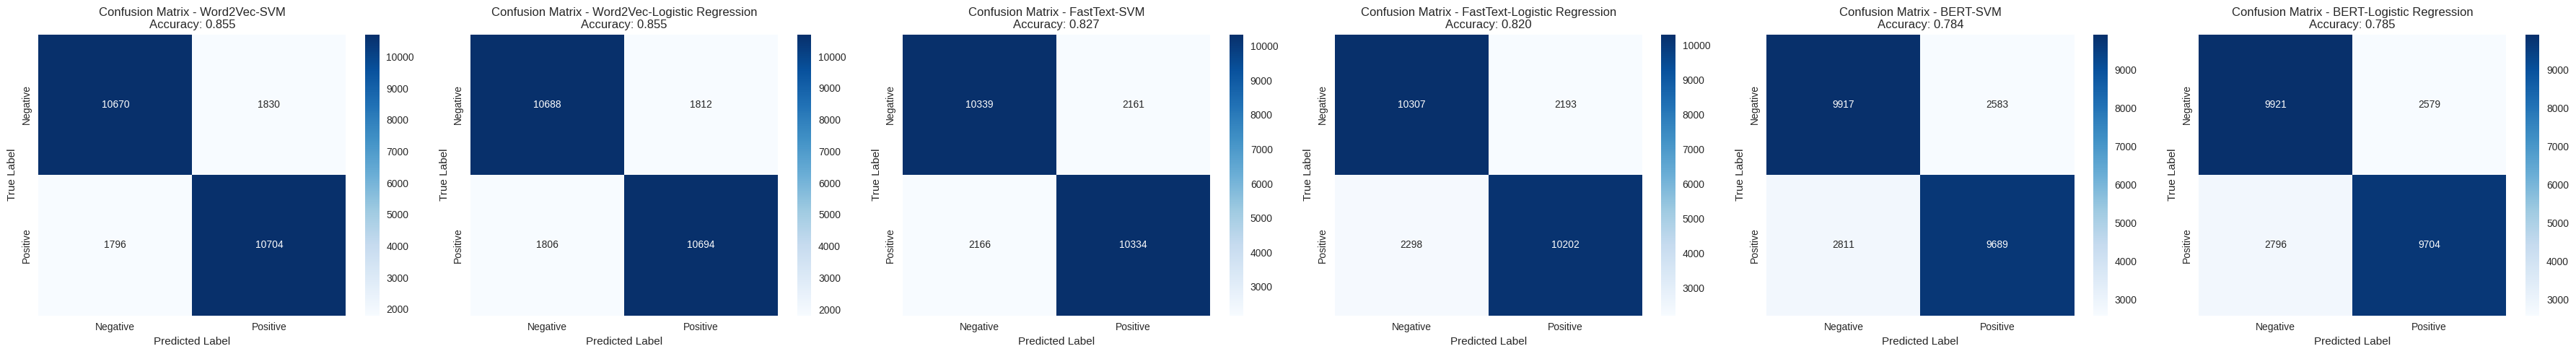

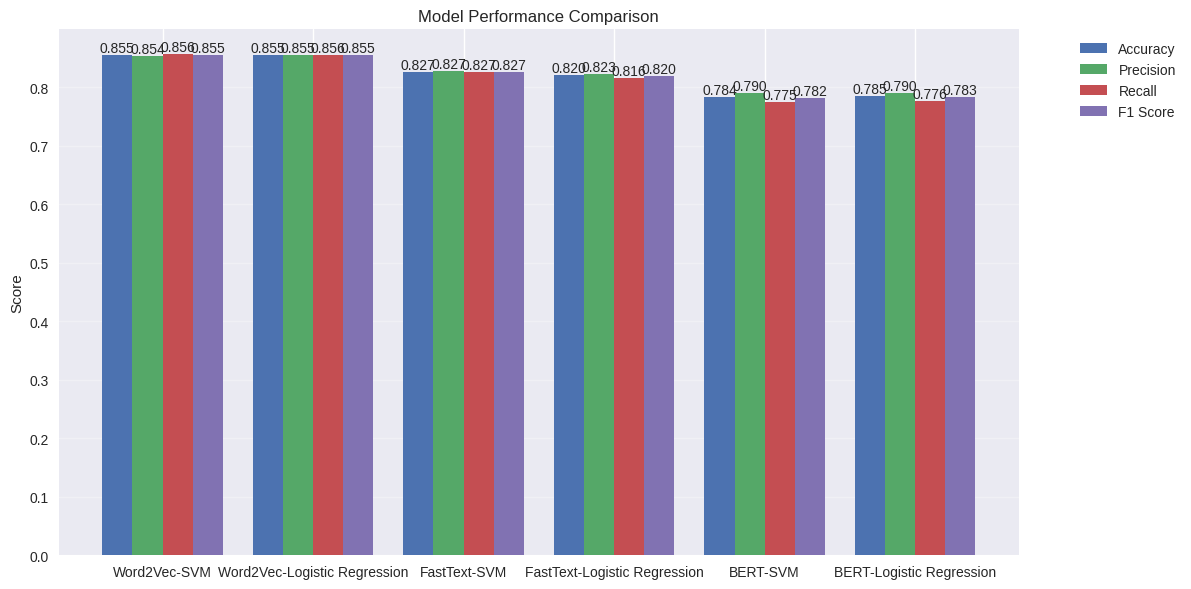

In [ ]:
    # Confusion matrices
    confusion_matrices_path = output_dir / 'confusion_matrices.png'
    plot_confusion_matrices(all_evaluation_results, str(confusion_matrices_path))

    # Performance comparison
    performance_comparison_path = output_dir / 'performance_comparison.png'
    plot_performance_comparison(all_evaluation_results, str(performance_comparison_path))
